In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

# ------------------- Define VGG-16 U-Net Model -------------------
def vgg16_unet(input_size=(256, 256, 3)):
    # Load pretrained VGG-16 model (without fully connected layers)
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_size)

    # Freeze VGG-16 layers (to keep pretrained weights)
    for layer in vgg16.layers:
        layer.trainable = False

    # Encoder (Feature Extractor)
    c1 = vgg16.get_layer("block1_conv2").output  # 256x256
    c2 = vgg16.get_layer("block2_conv2").output  # 128x128
    c3 = vgg16.get_layer("block3_conv3").output  # 64x64
    c4 = vgg16.get_layer("block4_conv3").output  # 32x32
    c5 = vgg16.get_layer("block5_conv3").output  # 16x16

    # Bottleneck
    b = Conv2D(1024, (3,3), activation='relu', padding='same')(c5)
    b = BatchNormalization()(b)
    b = Dropout(0.5)(b)
    b = Conv2D(1024, (3,3), activation='relu', padding='same')(b)
    b = BatchNormalization()(b)

    # Decoder (U-Net style upsampling)
    u6 = Conv2DTranspose(512, (2,2), strides=(2,2), padding='same')(b)
    u6 = concatenate([u6, c4])  # Skip connection
    c6 = Conv2D(512, (3,3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(512, (3,3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3,3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(256, (3,3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    u8 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3,3), activation='relu', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(128, (3,3), activation='relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    u9 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3,3), activation='relu', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(64, (3,3), activation='relu', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    outputs = Conv2D(1, (1,1), activation='sigmoid')(c9)

    model = Model(inputs=vgg16.input, outputs=outputs)
    return model

# ------------------- Compile Model -------------------
model = vgg16_unet()
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=binary_crossentropy,
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

model.summary()

  671744/58889256 ━━━━━━━━━━━━━━━━━━━━ 56s 1us/step 

In [ ]:
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split

# ------------------- Set Paths -------------------
image_folder = "/content/drive/MyDrive/Porosity DL Project/combined"
mask_folder = "/content/drive/MyDrive/Porosity DL Project/Binary"

IMG_SIZE = 256  # Resize to 256x256

# ------------------- Load Dataset -------------------
def load_data(image_folder, mask_folder):
    images, masks = [], []

    for filename in sorted(os.listdir(image_folder)):
        if filename.endswith(('.tif')):
            img_path = os.path.join(image_folder, filename)
            mask_path = os.path.join(mask_folder, filename)

            # Load and preprocess image
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (256, 256))
            img = img / 255.0  # Normalize to [0,1]

            # Convert to 3 channels (VGG-16 requirement)
            img = np.stack([img] * 3, axis=-1)  # Shape: (256, 256, 3)

            # Load and preprocess mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (256, 256))
            mask = mask / 255.0
            mask = np.expand_dims(mask, axis=-1)  # Shape: (256, 256, 1)

            images.append(img)
            masks.append(mask)

    return np.array(images), np.array(masks)

# Load dataset
X, Y = load_data(image_folder, mask_folder)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"✅ Data Loaded: {X.shape}, {Y.shape}")

✅ Data Loaded: (553, 256, 256, 3), (553, 256, 256, 1)


In [ ]:
from tensorflow.keras.metrics import MeanIoU

# Compile Model with IoU Metric
model.compile(optimizer=Adam(learning_rate=1e-4), loss=binary_crossentropy, metrics=['accuracy', MeanIoU(num_classes=2)])

BATCH_SIZE = 40
EPOCHS = 500

history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=BATCH_SIZE, epochs=EPOCHS)
model.save("VGGplusUnet.h5")
print("✅ Model Trained & Saved!")

Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 246s 9s/step - accuracy: 0.7391 - loss: 0.5641 - mean_io_u_1: 0.3279 - val_accuracy: 0.3445 - val_loss: 1.9022 - val_mean_io_u_1: 0.3277
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9802 - loss: 0.1107 - mean_io_u_1: 0.3279 - val_accuracy: 0.3445 - val_loss: 2.5710 - val_mean_io_u_1: 0.3277
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9852 - loss: 0.0518 - mean_io_u_1: 0.3279 - val_accuracy: 0.3446 - val_loss: 2.7955 - val_mean_io_u_1: 0.3277
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9857 - loss: 0.0421 - mean_io_u_1: 0.3279 - val_accuracy: 0.3457 - val_loss: 2.6456 - val_mean_io_u_1: 0.3277
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9859 - loss: 0.0388 - mean_io_u_1: 0.3279 - val_accuracy: 0.3490 - val_loss: 2.1256 - val_mean_io_u_1: 0.3277
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9860 - loss: 0.0362 - mean_io_u_1: 0.3279 - val_accuracy: 0

✅ Model Trained & Saved!


In [ ]:
# Evaluate Model
loss, accuracy, iou = model.evaluate(X_val, Y_val)
print(f"✅ Model Performance:")
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"IoU (Jaccard Index): {iou:.4f}")  # IoU should be between 0 and 1

4/4 ━━━━━━━━━━━━━━━━━━━━ 52s 7s/step - accuracy: 0.9871 - loss: 0.0167 - mean_io_u_1: 0.6675
✅ Model Performance:
Loss: 0.0166
Accuracy: 0.9872
IoU (Jaccard Index): 0.6655


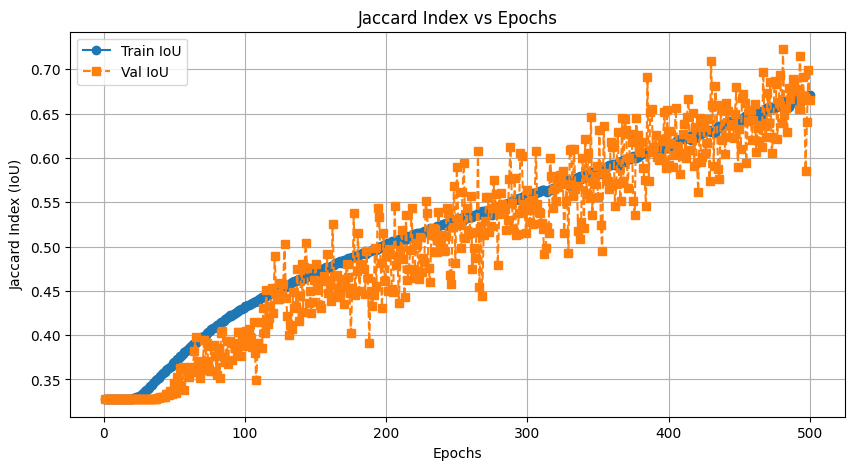

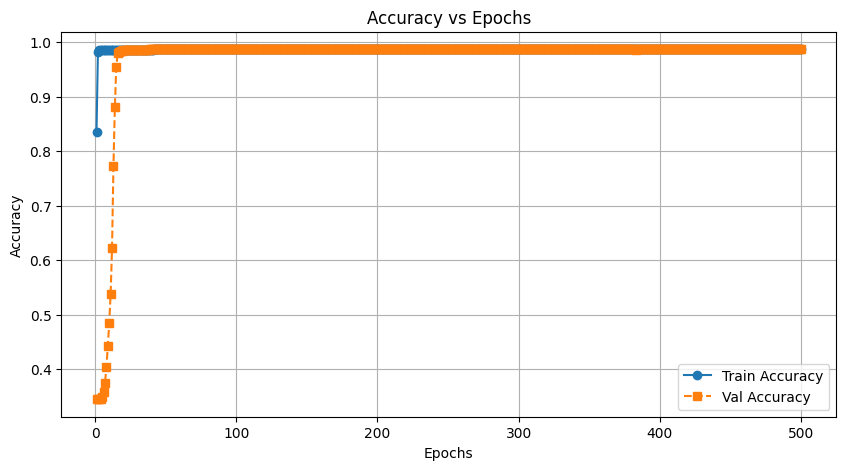

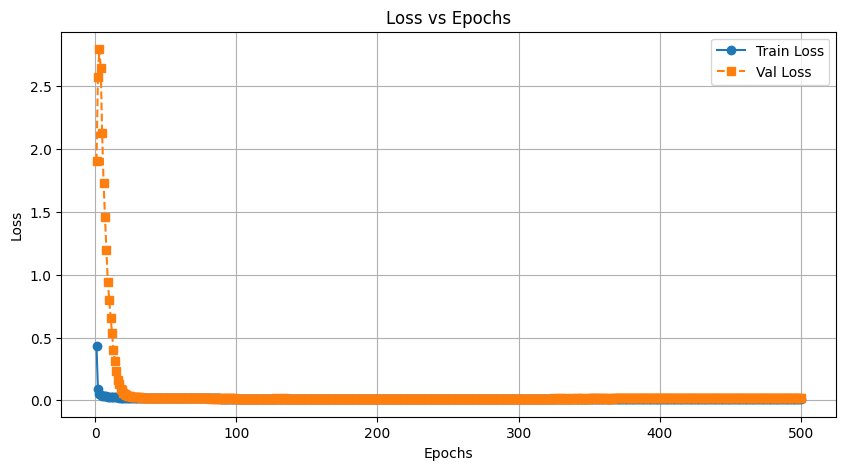

In [ ]:
import matplotlib.pyplot as plt

# Extract training history
epochs = range(1, EPOCHS + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_iou = history.history['mean_io_u_1']
val_iou = history.history['val_mean_io_u_1']

# Plot Jaccard Index (IoU) vs Epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_iou, label="Train IoU", marker='o', linestyle='-')
plt.plot(epochs, val_iou, label="Val IoU", marker='s', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Jaccard Index (IoU)")
plt.title("Jaccard Index vs Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy vs Epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label="Train Accuracy", marker='o', linestyle='-')
plt.plot(epochs, val_acc, label="Val Accuracy", marker='s', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot Loss vs Epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label="Train Loss", marker='o', linestyle='-')
plt.plot(epochs, val_loss, label="Val Loss", marker='s', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.grid()
plt.show()

In [ ]:
import cv2
import numpy as np
import os

# ------------------- Set Paths -------------------
input_folder = "/content/drive/MyDrive/Porosity/Binary"  # Folder containing binary images

# List to store results
results = []

# Loop through images
for filename in os.listdir(input_folder):
    if filename.endswith(".tif"):
        image_path = os.path.join(input_folder, filename)

        # Load binary image (0 = black, 255 = white)
        binary_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Get image dimensions
        height, width = binary_img.shape
        center = (width // 2, height // 2)
        radius = min(width, height) // 2  # Assuming the circle fits inside the square

        # Create a circular mask
        mask = np.zeros_like(binary_img)
        cv2.circle(mask, center, radius, 255, -1)  # Draw a white circle on a black background

        # Apply the mask to keep only circular region
        circular_region = cv2.bitwise_and(binary_img, mask)

        # Count total pixels inside the circle (both black and white)
        total_pixels_in_circle = np.count_nonzero(mask == 255)

        # Count black pixels (pores) inside the circle
        black_pixels_in_circle = np.count_nonzero((circular_region == 0) & (mask == 255))

        # Calculate porosity percentage
        porosity = (black_pixels_in_circle / total_pixels_in_circle) * 100

        # Store result
        results.append(porosity)


# Compute statistics
count_images = len(results)
min_porosity = min(results)
max_porosity = max(results)
mean_porosity = sum(results) / count_images

# Print final statistics
print(f"Porosity Statistics:")
print(f" Total Images: {count_images}")
print(f" Min Porosity: {min_porosity:.2f}%")
print(f" Max Porosity: {max_porosity:.2f}%")
print(f" Mean Porosity: {mean_porosity:.2f}%")